In [95]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
import re
import pyspark.sql.functions as f
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import NGram
from pyspark.ml.feature import MaxAbsScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.clustering import BisectingKMeans

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Jeopardy Calculation") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

In [96]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
def stem(in_vec):
    out_vec = []
    for t in in_vec:
        t_stem = stemmer.stem(t)
        out_vec.append(t_stem)       
    return out_vec
from pyspark.sql.types import *
stemmer_udf = udf(lambda x: stem(x), ArrayType(StringType()))

In [97]:
#reading in the jeopardy data set
jeopardy = spark.read.json("data/JEOPARDY_QUESTIONS1.json")

In [98]:
#This is the number of categories in the dataset which have greater than 100 observations
j_categoryCount = jeopardy.groupBy("category").count()
count100 = j_categoryCount.sort(desc("count")).filter(j_categoryCount["count"] > 100).count()
count100

145

# Changing limit to top 50 to see if that helps the bar graph at all

In [99]:
#This is a list of all categories which have a count greater than 100
top_categories = list(j_categoryCount.sort(desc("count")).select("category").limit(count100).toPandas().category)

In [100]:
jeo_f = jeopardy.where(col("category").isin(top_categories))

In [101]:
#stripping punctuation, tokenizing, and stop word removing for the modified dataset
jeo_fpunc = jeo_f.withColumn("stripped", f.regexp_replace(f.col("question"), "[\!@#$%^&*)(><,';:]", ""))
jeo_fpunc.cache()
tokenizer = Tokenizer(inputCol = "stripped", outputCol = "words")
tokenized_f = tokenizer.transform(jeo_fpunc)
tokenized_f.cache()
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
jeo_fStopRemoved = remover.transform(tokenized_f)
jeo_fStopRemoved.cache()

DataFrame[air_date: string, answer: string, category: string, question: string, round: string, show_number: string, value: string, stripped: string, words: array<string>, filtered: array<string>]

In [102]:
#stemming words in modified dataset
jeo_fStemmed = jeo_fStopRemoved.withColumn("stemmed", stemmer_udf("filtered"))
jeo_fStemmed.cache()

DataFrame[air_date: string, answer: string, category: string, question: string, round: string, show_number: string, value: string, stripped: string, words: array<string>, filtered: array<string>, stemmed: array<string>]

In [103]:
jeo_fStemmed.columns

['air_date',
 'answer',
 'category',
 'question',
 'round',
 'show_number',
 'value',
 'stripped',
 'words',
 'filtered',
 'stemmed']

In [104]:
jeo_fStemmed.select("stemmed").show(1, truncate=False)

+-----------------------------------------------------------------+
|stemmed                                                          |
+-----------------------------------------------------------------+
|[last, 8, year, life, galileo, hous, arrest, espous, man, theori]|
+-----------------------------------------------------------------+
only showing top 1 row



In [105]:
categories = jeo_fStemmed.groupby("category")

In [106]:
jeo_fStemmed.toPandas()

,air_date,answer,category,question,round,show_number,value,stripped,words,filtered,stemmed
0,2004-12-31,Copernicus,HISTORY,"'For the last 8 years of his life, Galileo was...",Jeopardy!,4680,$200,For the last 8 years of his life Galileo was u...,"[for, the, last, 8, years, of, his, life, gali...","[last, 8, years, life, galileo, house, arrest,...","[last, 8, year, life, galileo, hous, arrest, e..."
1,2004-12-31,the ant,3-LETTER WORDS,"'In the title of an Aesop fable, this insect s...",Jeopardy!,4680,$200,In the title of an Aesop fable this insect sha...,"[in, the, title, of, an, aesop, fable, this, i...","[title, aesop, fable, insect, shared, billing,...","[titl, aesop, fabl, insect, share, bill, grass..."
2,2004-12-31,the Appian Way,HISTORY,'Built in 312 B.C. to link Rome & the South of...,Jeopardy!,4680,$400,Built in 312 B.C. to link Rome the South of I...,"[built, in, 312, b.c., to, link, rome, , the, ...","[built, 312, b.c., link, rome, , south, italy,...","[built, 312, b.c., link, rome, , south, itali,..."
3,2004-12-31,the cud,3-LETTER WORDS,'Cows regurgitate this from the first stomach ...,Jeopardy!,4680,$400,Cows regurgitate this from the first stomach t...,"[cows, regurgitate, this, from, the, first, st...","[cows, regurgitate, first, stomach, mouth, , c...","[cow, regurgit, first, stomach, mouth, , chew]"
4,2004-12-31,Ceylon (or Sri Lanka),HISTORY,'In 1000 Rajaraja I of the Cholas battled to t...,Jeopardy!,4680,$600,In 1000 Rajaraja I of the Cholas battled to ta...,"[in, 1000, rajaraja, i, of, the, cholas, battl...","[1000, rajaraja, cholas, battled, take, indian...","[1000, rajaraja, chola, battl, take, indian, o..."
5,2004-12-31,imp,3-LETTER WORDS,"'A small demon, or a mischievous child (who mi...",Jeopardy!,4680,$600,A small demon or a mischievous child who might...,"[a, small, demon, or, a, mischievous, child, w...","[small, demon, mischievous, child, might, litt...","[small, demon, mischiev, child, might, littl, ..."
6,2004-12-31,the International,HISTORY,'Karl led the first of these Marxist organizat...,Jeopardy!,4680,$800,Karl led the first of these Marxist organizati...,"[karl, led, the, first, of, these, marxist, or...","[karl, led, first, marxist, organizational, ef...","[karl, led, first, marxist, organiz, effort, s..."
7,2004-12-31,era,3-LETTER WORDS,"'In geologic time one of these, shorter than a...",Jeopardy!,4680,$800,In geologic time one of these shorter than an ...,"[in, geologic, time, one, of, these, shorter, ...","[geologic, time, one, shorter, eon, divided, p...","[geolog, time, one, shorter, eon, divid, perio..."
8,2004-12-31,the Congress Party,HISTORY,'This Asian political party was founded in 188...,Jeopardy!,4680,$1000,This Asian political party was founded in 1885...,"[this, asian, political, party, was, founded, ...","[asian, political, party, founded, 1885, ""indi...","[asian, polit, parti, found, 1885, ""indian, na..."
9,2004-12-31,ply,3-LETTER WORDS,"'A single layer of paper, or to perform one's ...",Jeopardy!,4680,$1000,A single layer of paper or to perform ones cra...,"[a, single, layer, of, paper, or, to, perform,...","[single, layer, paper, perform, ones, craft, d...","[singl, layer, paper, perform, one, craft, dilig]"


In [107]:
jeopardy = jeo_fStemmed.toPandas()

In [108]:
jeopardy.head()

,air_date,answer,category,question,round,show_number,value,stripped,words,filtered,stemmed
0,2004-12-31,Copernicus,HISTORY,"'For the last 8 years of his life, Galileo was...",Jeopardy!,4680,$200,For the last 8 years of his life Galileo was u...,"[for, the, last, 8, years, of, his, life, gali...","[last, 8, years, life, galileo, house, arrest,...","[last, 8, year, life, galileo, hous, arrest, e..."
1,2004-12-31,the ant,3-LETTER WORDS,"'In the title of an Aesop fable, this insect s...",Jeopardy!,4680,$200,In the title of an Aesop fable this insect sha...,"[in, the, title, of, an, aesop, fable, this, i...","[title, aesop, fable, insect, shared, billing,...","[titl, aesop, fabl, insect, share, bill, grass..."
2,2004-12-31,the Appian Way,HISTORY,'Built in 312 B.C. to link Rome & the South of...,Jeopardy!,4680,$400,Built in 312 B.C. to link Rome the South of I...,"[built, in, 312, b.c., to, link, rome, , the, ...","[built, 312, b.c., link, rome, , south, italy,...","[built, 312, b.c., link, rome, , south, itali,..."
3,2004-12-31,the cud,3-LETTER WORDS,'Cows regurgitate this from the first stomach ...,Jeopardy!,4680,$400,Cows regurgitate this from the first stomach t...,"[cows, regurgitate, this, from, the, first, st...","[cows, regurgitate, first, stomach, mouth, , c...","[cow, regurgit, first, stomach, mouth, , chew]"
4,2004-12-31,Ceylon (or Sri Lanka),HISTORY,'In 1000 Rajaraja I of the Cholas battled to t...,Jeopardy!,4680,$600,In 1000 Rajaraja I of the Cholas battled to ta...,"[in, 1000, rajaraja, i, of, the, cholas, battl...","[1000, rajaraja, cholas, battled, take, indian...","[1000, rajaraja, chola, battl, take, indian, o..."


In [109]:
categories = jeopardy.groupby("category")

In [110]:
categories.head()

,air_date,answer,category,question,round,show_number,value,stripped,words,filtered,stemmed
0,2004-12-31,Copernicus,HISTORY,"'For the last 8 years of his life, Galileo was...",Jeopardy!,4680,$200,For the last 8 years of his life Galileo was u...,"[for, the, last, 8, years, of, his, life, gali...","[last, 8, years, life, galileo, house, arrest,...","[last, 8, year, life, galileo, hous, arrest, e..."
1,2004-12-31,the ant,3-LETTER WORDS,"'In the title of an Aesop fable, this insect s...",Jeopardy!,4680,$200,In the title of an Aesop fable this insect sha...,"[in, the, title, of, an, aesop, fable, this, i...","[title, aesop, fable, insect, shared, billing,...","[titl, aesop, fabl, insect, share, bill, grass..."
2,2004-12-31,the Appian Way,HISTORY,'Built in 312 B.C. to link Rome & the South of...,Jeopardy!,4680,$400,Built in 312 B.C. to link Rome the South of I...,"[built, in, 312, b.c., to, link, rome, , the, ...","[built, 312, b.c., link, rome, , south, italy,...","[built, 312, b.c., link, rome, , south, itali,..."
3,2004-12-31,the cud,3-LETTER WORDS,'Cows regurgitate this from the first stomach ...,Jeopardy!,4680,$400,Cows regurgitate this from the first stomach t...,"[cows, regurgitate, this, from, the, first, st...","[cows, regurgitate, first, stomach, mouth, , c...","[cow, regurgit, first, stomach, mouth, , chew]"
4,2004-12-31,Ceylon (or Sri Lanka),HISTORY,'In 1000 Rajaraja I of the Cholas battled to t...,Jeopardy!,4680,$600,In 1000 Rajaraja I of the Cholas battled to ta...,"[in, 1000, rajaraja, i, of, the, cholas, battl...","[1000, rajaraja, cholas, battled, take, indian...","[1000, rajaraja, chola, battl, take, indian, o..."
5,2004-12-31,imp,3-LETTER WORDS,"'A small demon, or a mischievous child (who mi...",Jeopardy!,4680,$600,A small demon or a mischievous child who might...,"[a, small, demon, or, a, mischievous, child, w...","[small, demon, mischievous, child, might, litt...","[small, demon, mischiev, child, might, littl, ..."
6,2004-12-31,the International,HISTORY,'Karl led the first of these Marxist organizat...,Jeopardy!,4680,$800,Karl led the first of these Marxist organizati...,"[karl, led, the, first, of, these, marxist, or...","[karl, led, first, marxist, organizational, ef...","[karl, led, first, marxist, organiz, effort, s..."
7,2004-12-31,era,3-LETTER WORDS,"'In geologic time one of these, shorter than a...",Jeopardy!,4680,$800,In geologic time one of these shorter than an ...,"[in, geologic, time, one, of, these, shorter, ...","[geologic, time, one, shorter, eon, divided, p...","[geolog, time, one, shorter, eon, divid, perio..."
8,2004-12-31,the Congress Party,HISTORY,'This Asian political party was founded in 188...,Jeopardy!,4680,$1000,This Asian political party was founded in 1885...,"[this, asian, political, party, was, founded, ...","[asian, political, party, founded, 1885, ""indi...","[asian, polit, parti, found, 1885, ""indian, na..."
9,2004-12-31,ply,3-LETTER WORDS,"'A single layer of paper, or to perform one's ...",Jeopardy!,4680,$1000,A single layer of paper or to perform ones cra...,"[a, single, layer, of, paper, or, to, perform,...","[single, layer, paper, perform, ones, craft, d...","[singl, layer, paper, perform, one, craft, dilig]"


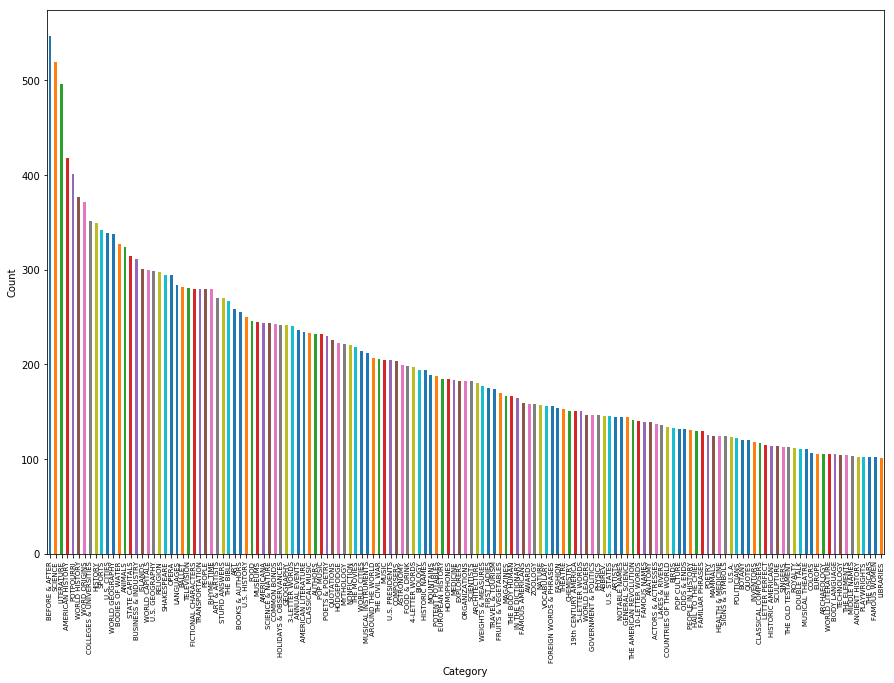

In [132]:
plt.figure(figsize=(15,10))
categories.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=90, fontsize="x-small")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [112]:
text = jeo_fStemmed.select("question")

In [113]:
text1 = text.toPandas()

In [114]:
text1.head()

,question
0,"'For the last 8 years of his life, Galileo was..."
1,"'In the title of an Aesop fable, this insect s..."
2,'Built in 312 B.C. to link Rome & the South of...
3,'Cows regurgitate this from the first stomach ...
4,'In 1000 Rajaraja I of the Cholas battled to t...


In [115]:
jeo_f.count()

29252

In [116]:
jeopardyText = jeo_f.select("question")

In [117]:
jeopardyText.coalesce(1).write.format("text").option("header", "false").mode("append").save("<path>")

In [118]:
text_file = spark.sparkContext.textFile("Questions.txt")

In [119]:
text_file.take(5)

["'For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory'",
 "'In the title of an Aesop fable, this insect shared billing with a grasshopper'",
 "'Built in 312 B.C. to link Rome & the South of Italy, it's still in use today'",
 "'Cows regurgitate this from the first stomach to the mouth & chew it again'",
 "'In 1000 Rajaraja I of the Cholas battled to take this Indian Ocean island now known for its tea'"]

In [120]:
questions = pd.read_txt("Questions.txt")

AttributeError: module 'pandas' has no attribute 'read_txt'

In [121]:
stringText = str(text1)

In [122]:
type(stringText)

str

In [129]:
wordcloud = WordCloud(max_words=100, width=800, height=400, background_color="white").generate(stringText)

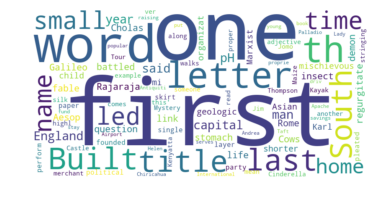

In [130]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()